In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from rich import print
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
import joblib

import warnings

pd.set_option("display.max_columns", None)
# warnings.filterwarnings('ignore')

## Model Pipeline


Based on the feature engineering done in the previous section, we can contain all the preprocessing steps with an sklearn pipeline which keeps all preprocessing steps, model building and validation in the one place.
Steps include:

- Ordinal encoding
- Scale numerical data
- drop uninformative features
- principle component analysis
- KMeans clustering
- Target encoding
- One-hot encoding
- feature creation


## Load data


In [2]:
# load data
dir = Path().resolve().parents[0] / "data" / "final"

In [3]:
train_path = dir / "fin_train.pkl"
test_path = dir / "fin_test.pkl"

train_df = pd.read_pickle(train_path)
X_test = pd.read_pickle(test_path)

In [4]:
train_df.head(2)

,LotFrontage,LotArea,LotShape,Utilities,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior2nd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,SalePrice,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PC1,cluster,GrLivArea,AreaRoomRatio,GarageAreaPerCar,BathBedroomRatio,LandPropertyRatio
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.220875,-0.207142,3.0,0.0,-0.211518,6.0,4.0,1.050994,0.878668,0.143911,0.514104,2.0,4.0,2.0,4.0,3.0,2.0,0.575425,6.0,-0.944591,-0.459303,0.0,1.0,5.0,-0.793434,1.161852,1.107810,0.789741,1.227585,0.163779,-0.211454,2.0,0.912210,6.0,-0.951226,3.0,1.017598,2.0,0.311725,0.351000,5.0,5.0,2.0,-0.752176,0.216503,-0.359325,-0.270208,4.0,208500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.50523,4,0.370333,0.405974,1.125995,4.821985,-0.861431
2,0.460320,-0.091886,3.0,0.0,-0.278367,5.0,7.0,0.156734,-0.429577,-0.323985,-0.570750,3.0,4.0,2.0,4.0,1.0,0.0,1.171992,6.0,-0.641228,0.466465,0.0,1.0,5.0,0.257140,-0.795163,-0.819964,0.789741,-0.761621,0.163779,-0.211454,3.0,-0.318683,6.0,0.600495,5.0,-0.107927,2.0,0.311725,-0.060731,5.0,5.0,2.0,1.626195,-0.704483,-0.359325,-0.270208,4.0,181500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.35290,0,-0.482512,1.514080,-0.194823,4.821985,-0.335127


In [95]:
# split data
X = train_df.drop(columns=["SalePrice"])
y = train_df["SalePrice"].copy()
y = np.log1p(y)

In [6]:
train_cols = X.columns.tolist()
test_cols = X_test.columns.tolist()


train_col_drop = [col for col in train_cols if col not in test_cols]
test_col_drop = [col for col in test_cols if col not in train_cols]

X = X.drop(columns=train_col_drop)
X_test = X_test.drop(columns=test_col_drop)

## Model comparison pipeline


In [87]:
def cross_val_model(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42).get_n_splits(X.values)
    scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
    scores = np.sqrt(scores)

    print(
        f"RMSLE: {scores}\n Mean: {scores.mean()}\n Standard deviation: {scores.std()}"
    )

    return scores.mean(), scores

In [88]:
def model_eval_pipeline(model_pipe, X, y):
    model_mean_scores = []
    model_scores = []

    for name, model in model_pipe:
        print(f"Cross-validating {name}")

        # return RMSLE scores
        mean_score, scores = cross_val_model(model, X, y)

        # append results
        model_mean_scores.append(mean_score)
        model_scores.append({name: scores})

    # get the best model
    smallest_score = min(model_mean_scores)
    index_pos = model_mean_scores.index(smallest_score)
    model = model_pipe[index_pos]

    print(f"Best model: {model[0]} with RMSLE: {smallest_score}")

    return model[1], model_scores

In [96]:
model_names = [
    "Gradient Boosting Regressor",
    "Random Forest Regressor",
    "Hist Gradient Boosting Regressor", 
    "XGBoost Regressor",
    'Kernel Ridge Regressor',
    'Lasso Regressor',
]

models = [
    GradientBoostingRegressor(random_state=42, loss='huber'),
    # GradientBoostingRegressor(
    #     n_estimators=3000,
    #     learning_rate=0.05,
    #     max_depth=4,
    #     max_features="sqrt",
    #     min_samples_leaf=15,
    #     min_samples_split=10,
    #     loss="huber",
    #     random_state=42,
    # ),
    RandomForestRegressor(random_state=42),
    HistGradientBoostingRegressor(random_state=42),
    XGBRegressor(),
    KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
    Lasso(alpha =0.0005, random_state=42)
]

model_pipe = list(zip(model_names, models))

best_model, model_scores = model_eval_pipeline(model_pipe, X, y)

# output best model
joblib.dump(best_model, Path().cwd().parent / "models" / "base" / "gbr_best_model.pkl")

best_model

Cross-validating Gradient Boosting Regressor

RMSLE: [22211.23302399 28676.49195769 33305.34153727 23599.68576739
 31910.58712591]
 Mean: 27940.667882449547
 Standard deviation: 4398.908246660783

Cross-validating Random Forest Regressor

RMSLE: [23586.61634304 33474.96271358 30852.01901765 25996.71839781
 32023.06442632]
 Mean: 29186.676179679354
 Standard deviation: 3761.4988309069045

Cross-validating Hist Gradient Boosting Regressor

RMSLE: [23562.36074579 32060.98111829 30254.58739736 22833.03016107
 30322.83425119]
 Mean: 27806.75873474147
 Standard deviation: 3825.540470778272

Cross-validating XGBoost Regressor

RMSLE: [23441.70813943 33212.286837   32787.31060887 23668.81515783
 30356.91632169]
 Mean: 28693.407412962475
 Standard deviation: 4307.538719636203

Cross-validating Kernel Ridge Regressor

RMSLE: [24278.49901397 65868.63976863 27359.83981643 20601.71615879
 29483.86330672]
 Mean: 33518.511612907496
 Standard deviation: 16449.679963909257

Cross-validating Lasso Regressor

/Users/conal/Projects/kaggle_comps/house_prices_adv_reg/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.638e+11, tolerance: 7.592e+08
  model = cd_fast.enet_coordinate_descent(
/Users/conal/Projects/kaggle_comps/house_prices_adv_reg/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.937e+11, tolerance: 7.288e+08
  model = cd_fast.enet_coordinate_descent(
/Users/conal/Projects/kaggle_comps/house_prices_adv_reg/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might wa

RMSLE: [25701.29858802 34516.40726378 32396.69228209 27737.27410953
 46332.24158772]
 Mean: 33336.782766226504
 Standard deviation: 7222.359031325936

Best model: Hist Gradient Boosting Regressor with RMSLE: 27806.75873474147

HistGradientBoostingRegressor(random_state=42)

The best model without any tuning is the Gradient Boosting Regressor, followed by XGBoost Regressor, and lastly Random Forest Regressor


In [10]:
def model_comp_plot(data: list[dict[str, int]]) -> None:
    """Plot the model performance for each K-fold.

    Args:
        data (list[dict[str, int]]): list containing MAE scores for each K-fold
    """
    # unpack model scores
    scores = {list(item.keys())[0]: item[list(item.keys())[0]] for item in data}

    # Create a Pandas DataFrame
    df = pd.DataFrame(scores)
    df["K-fold"] = df.index + 1
    df = df.melt(id_vars=["K-fold"], var_name="Model", value_name="RMSLE")

    # plot
    sns.lineplot(data=df, x="K-fold", y="RMSLE", hue="Model")
    plt.title("RMSLE for each K-fold - Model Comparison")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

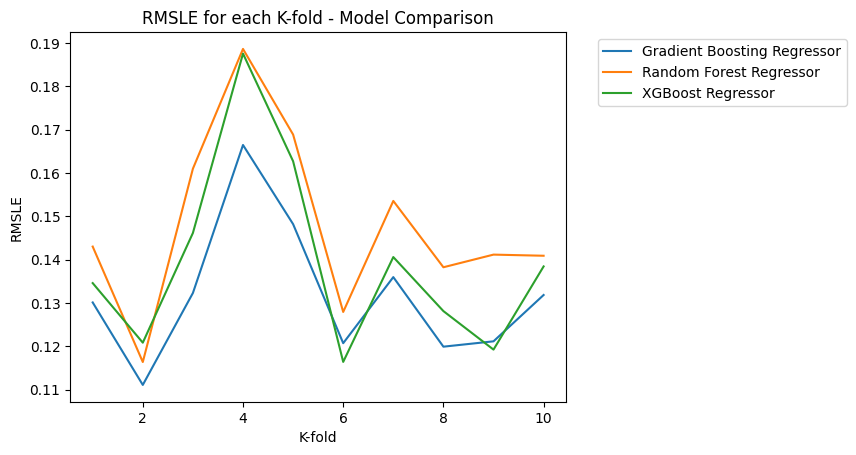

In [11]:
model_comp_plot(model_scores)

In [12]:
def grid_search_tuning(model, params, X, y):
    grid_search = GridSearchCV(
        model,
        param_grid=params,
        cv=10,
        scoring="neg_mean_squared_log_error",
        n_jobs=-1,
    )
    grid_search.fit(X, y)

    return grid_search.best_estimator_, grid_search.cv_results_

In [13]:
def random_search_tuning(model, params, X, y):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=params,
        # n_iter=100,
        cv=10,
        scoring="neg_mean_squared_log_error",
        n_jobs=-1,
    )
    random_search.fit(X, y)

    return random_search.best_estimator_, random_search.cv_results_

In [14]:
def hyperparameter_tuning_results(cv_results: dict[str, np.ndarray]) -> list:
    return [
        (-mean_score, params)
        for mean_score, params in zip(
            cv_results["mean_test_score"], cv_results["params"]
        )
    ]

In [15]:
grid_parameters = {
    "loss": ["ls", "lad", "huber", "quantile"],
    "learning_rate": [0.01, 0.05, 0.1, 0.5],
    "n_estimators": [100, 500, 1000, 2000],
    "max_depth": [3, 5, 10, 15],
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["auto", "sqrt", "log2"],
    "subsample": [0.5, 0.75, 1.0],
}

In [16]:
# best_estimator, cv_results = grid_search_tuning(best_model, grid_parameters, X, y)

# rmsle_scores = hyperparameter_tuning_results(cv_results)

# print(rmsle_scores)

In [66]:
random_params = {
    "n_estimators": stats.randint(50, 200),
    "max_depth": stats.randint(2, 6),
    'n_iter_no_change': stats.randint(5, 20),
    # "min_samples_split": stats.randint(2, 15),
    # "min_samples_leaf": stats.randint(1, 10),
    # 'max_features': random.choice(['sqrt', 'log2']),
    # "subsample": stats.uniform(0.5, 1.0),
    "learning_rate": [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.49]
    # 'loss': random.choice(['squared_error', 'absolute_error', 'huber', 'quantile'])
}

In [67]:
best_estimator, cv_results = random_search_tuning(best_model, random_params, X, y)

rmsle_scores = hyperparameter_tuning_results(cv_results)

print(rmsle_scores)

[
    (0.021121653547569383, {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 154, 'n_iter_no_change': 10}),
    (0.02537551258608472, {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 57, 'n_iter_no_change': 6}),
    (0.017237711390404215, {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 86, 'n_iter_no_change': 17}),
    (0.05135258151927681, {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 102, 'n_iter_no_change': 18}),
    (0.020239992917464818, {'learning_rate': 0.49, 'max_depth': 3, 'n_estimators': 73, 'n_iter_no_change': 9}),
    (0.018189910028379087, {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 159, 'n_iter_no_change': 11}),
    (0.021127919500958575, {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 136, 'n_iter_no_change': 16}),
    (0.02101276305767602, {'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 128, 'n_iter_no_change': 7}),
    (0.020052535936306317, {'learning_rate': 0.49, 'max_depth': 2, 'n_estimators': 149, 'n_iter_no_change': 17}),
    (0.020739134425231488, {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 143, 'n_iter_no_change': 8})
]

In [68]:
# output tuned model
joblib.dump(best_estimator, Path().cwd().parent / "models" / "tuned" / "gbr_tuned_model.pkl")

best_estimator

GradientBoostingRegressor(max_depth=4, n_estimators=86, n_iter_no_change=17,
                          random_state=42)

## Feature Importances


In [69]:
feature_importance = best_estimator.feature_importances_
importance_df = pd.DataFrame(
    {"features": X.columns, "importance": feature_importance}
).sort_values(by="importance", ascending=False)

In [70]:
importance_df

,features,importance
71,PC1,0.696027
5,OverallQual,0.084253
4,Neighborhood,0.038579
73,GrLivArea,0.033484
17,BsmtFinSF1,0.017666
...,...,...
55,SaleType_Oth,0.000000
52,SaleType_ConLI,0.000000
51,SaleType_ConLD,0.000000
49,SaleType_CWD,0.000000


In [71]:
def feature_importance_plot(data: pd.DataFrame):
    # Creating a bar chart
    plt.figure(figsize=(6, 6))
    sns.barplot(x="importance", y="features", data=data[data["importance"] != 0])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.grid(axis="x")

    # Display the chart
    plt.show()

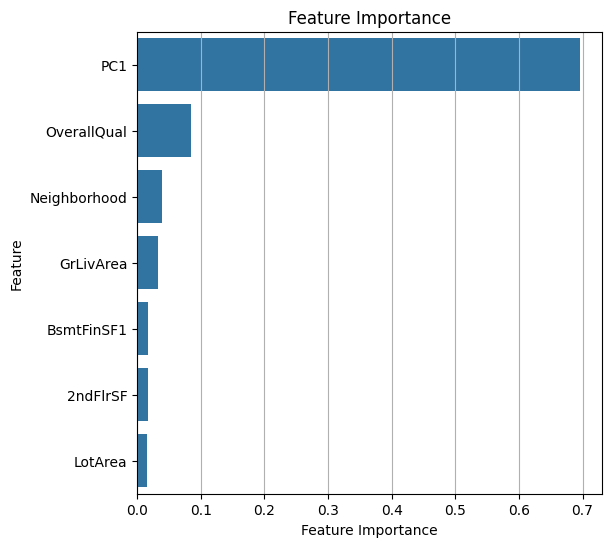

In [72]:
feature_importance_plot(importance_df.loc[importance_df["importance"] > 0.01])

## Predict test set


Tuned model

In [73]:
final_pred = best_estimator.predict(X_test)

In [74]:
output = pd.DataFrame({"Id": X_test.index, "SalePrice": final_pred})

In [75]:
output_path = Path().cwd().parent / "output" / "tuned_gbr_results.csv"
output.to_csv(output_path, index=False)

In [76]:
output.head(2)

,Id,SalePrice
0,1461,137596.095146
1,1462,156713.268550


Base model

The initial tuned result score (0.158) indicates there is suspected overfitting in the model, try with base GBR model and see what the result is

In [31]:
best_model.fit(X, y)

GradientBoostingRegressor(random_state=42)

In [32]:
y_pred = best_model.predict(X_test)

In [33]:
base_output = pd.DataFrame({"Id": X_test.index, "SalePrice": y_pred})

In [35]:
output_path = Path().cwd().parent / "output" / "base_gbr_results.csv"
base_output.to_csv(output_path, index=False)

## Stacking

I want to stack the base models together to see if they produce a more accurate result

In [39]:
stacking_reg = StackingRegressor(
    estimators=[
        ("gbr", XGBRegressor()),
        ("rfr", RandomForestRegressor(random_state=42)),
    ],
    final_estimator=best_model,
    cv=5,
)

In [40]:
stacking_reg.fit(X, y)

StackingRegressor(cv=5,
                  estimators=[('gbr',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('rfr', RandomForestRegressor(random_state=42))],
                  final_estimator=GradientBoostingRegressor(random_state=42))

In [43]:
stacked_pred = stacking_reg.predict(X_test)

In [44]:
stacked_output = pd.DataFrame({"Id": X_test.index, "SalePrice": stacked_pred})
stacked_output

,Id,SalePrice
0,1461,136766.454932
1,1462,149871.864365
2,1463,187832.458651
3,1464,175739.061235
4,1465,176795.017250
...,...,...
1454,2915,81852.319740
1455,2916,85944.184835
1456,2917,180733.461804
1457,2918,117828.825249


In [45]:
output_path = Path().cwd().parent / "output" / "stacked_results.csv"
stacked_output.to_csv(output_path, index=False)